In [1]:
import pandas as pd
import re
import ast
import os

from test_llm_translation_indx import get_db_conn
from spider_difficulty_evaluation import eval_hardness
from process_sql import get_sql, get_schema, Schema


C:\Users\tonyk\gatech\cs8803-research\test_llm_translation_indx.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  existing_db = pd.read_sql("select * from gatech.\"spider_dataset_GPT_labels\"", get_db_conn())


In [2]:
# weak_column_labels = pd.read_csv('Spider Dataset Weak Labels V2.csv')
weak_column_labels = pd.read_csv('Spider Dataset Weak Labels NQ.csv')

In [3]:
weak_column_labels.columns

Index(['Unnamed: 0', 'Column1.db_id', 'Column1.query', 'Column1.question',
       'Query Type', 'outer_query_identifiers', 'inner_queries',
       'num_inner_queries', 'difficulty', 'nested_query_type'],
      dtype='object')

In [4]:
gpt_labels1 = pd.read_sql("select * from gatech.\"spider_query_understanding\"", get_db_conn())

C:\Users\tonyk\AppData\Local\Temp\ipykernel_69212\2758388274.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  gpt_labels1 = pd.read_sql("select * from gatech.\"spider_query_understanding\"", get_db_conn())


In [5]:
gpt_labels1.columns

Index(['db_id', 'question', 'token_annotations', 'nested_query_annotations',
       'nqt_len'],
      dtype='object')

In [6]:
merged_df = pd.merge(gpt_labels1, weak_column_labels, how='left', left_on=['db_id','question'], right_on =['Column1.db_id', 'Column1.question'])

In [7]:
merged_df.columns

Index(['db_id', 'question', 'token_annotations', 'nested_query_annotations',
       'nqt_len', 'Unnamed: 0', 'Column1.db_id', 'Column1.query',
       'Column1.question', 'Query Type', 'outer_query_identifiers',
       'inner_queries', 'num_inner_queries', 'difficulty',
       'nested_query_type'],
      dtype='object')

In [8]:
(merged_df['nested_query_type']).isna()

0        True
1        True
2        True
3        True
4        True
        ...  
7058    False
7059    False
7060     True
7061     True
7062     True
Name: nested_query_type, Length: 7063, dtype: bool

In [9]:
merged_df[(merged_df['nqt_len'] > 0) & ~((merged_df['nested_query_type']).isna())]

db_id  \
82                          book_2   
156                        musical   
318                      network_2   
366                         ship_1   
381                      network_2   
...                            ...   
6890  tracking_grants_for_research   
6925                    race_track   
6930                    race_track   
6996                    race_track   
7015                   solvency_ii   

                                               question  \
82     List the titles of books that are not published.   
156   List the name of musicals that do not have act...   
318   What is the name of all the people who are old...   
366   Return the names and classes of ships that do ...   
381   Find the number of people whose age is greater...   
...                                                 ...   
6890  What are the details for the projects which we...   
6925  Show the name, location, open year for all tra...   
6930  What are the names, locations, and years of op...   
6996  Return the names of tracks that have no had an...   
7015  List the names of products that are not in any...   

                                      token_annotations  \
82    {'characters': {'0': 'List', '1': 'the', '2': ...   
156   {'characters': {'0': 'List', '1': 'the', '2': ...   
318   {'characters': {'0': 'What', '1': 'is', '2': '...   
366   {'characters': {'0': 'Return', '1': 'the', '2'...   
381   {'characters': {'0': 'Find', '1': 'the', '2': ...   
...                                                 ...   
6890  {'characters': {'0': 'What', '1': 'are', '2': ...   
6925  {'characters': {'0': 'Show', '1': 'the', '2': ...   
6930  {'characters': {'0': 'What', '1': 'are', '2': ...   
6996  {'characters': {'0': 'Return', '1': 'the', '2'...   
7015  {'characters': {'0': 'List', '1': 'the', '2': ...   

                               nested_query_annotations  nqt_len  Unnamed: 0  \
82    {'characters': {'0': 'not'}, 'related_database...        1         229   
156   {'characters': {'0': 'not'}, 'related_database...        1         268   
318   {'characters': {'0': 'older'}, 'related_databa...        1        4431   
366   {'characters': {'0': 'not'}, 'related_database...        1        6261   
381   {'characters': {'0': 'is'}, 'related_database_...        1        4432   
...                                                 ...      ...         ...   
6890  {'characters': {'0': 'projects'}, 'related_dat...        1        4385   
6925  {'characters': {'0': 'higher'}, 'related_datab...        1         757   
6930  {'characters': {'0': 'higher'}, 'related_datab...        1         758   
6996  {'characters': {'0': 'no'}, 'related_database_...        1         776   
7015  {'characters': {'0': 'not'}, 'related_database...        1        4597   

                     Column1.db_id  \
82                          book_2   
156                        musical   
318                      network_2   
366                         ship_1   
381                      network_2   
...                            ...   
6890  tracking_grants_for_research   
6925                    race_track   
6930                    race_track   
6996                    race_track   
7015                   solvency_ii   

                                          Column1.query  \
82    SELECT Title FROM book WHERE Book_ID NOT IN (S...   
156   SELECT Name FROM musical WHERE Musical_ID NOT ...   
318   SELECT name FROM Person WHERE age  >  (SELECT ...   
366   SELECT name ,  CLASS FROM ship WHERE ship_id N...   
381   SELECT count(*) FROM Person WHERE age  >  (SEL...   
...                                                 ...   
6890  SELECT project_details FROM Projects WHERE org...   
6925  SELECT name ,  LOCATION ,  year_opened FROM tr...   
6930  SELECT name ,  LOCATION ,  year_opened FROM tr...   
6996  SELECT name FROM track WHERE track_id NOT IN (...   
7015  SELECT Product_Name FROM Products WHERE Produc...   

                           

In [10]:
import json

In [11]:
outer_query = pd.DataFrame(merged_df.iloc[48]['nested_query_annotations']).outer_query.iloc[0]
inner_query = pd.DataFrame(merged_df.iloc[48]['nested_query_annotations']).inner_query.iloc[0]

pd.read_json(json.loads(outer_query))

AttributeError: 'DataFrame' object has no attribute 'outer_query'

In [ ]:
pd.read_json(json.loads(inner_query))

In [13]:
nq_detector_correct = []
for _, r in merged_df.iterrows():
    if r['nqt_len'] > 0 and not pd.isna(r['nested_query_type']):
        nq_detector_correct.append(True)
    elif r['nqt_len'] == 0 and  pd.isna(r['nested_query_type']):
        nq_detector_correct.append(True)
    else:
        nq_detector_correct.append(False)

In [14]:
def is_close_subsequence(main_str, substr, max_skips=2):
    main_words = main_str.split()
    sub_words = substr.split()
    
    def match_from_index(start_i, sub_words):
        skips = 0
        j = 0  # Index for sub_words
        for i in range(start_i, len(main_words)):
            if main_words[i] == sub_words[j]:
                j += 1
                if j == len(sub_words):
                    # Reached the end of sub_words, all words matched
                    return i, skips
            else:
                skips += 1
                if skips > max_skips:
                    # Too many skips, not a match from this start index
                    return -1, skips
        return -1, skips
    
    closest_match = float('inf')  # Initialize closest match distance to infinity
    for i, word in enumerate(main_words):
        if word == sub_words[0]:  # When the first word of the subsequence is found
            end_idx, num_skips = match_from_index(i, sub_words)
            if end_idx != -1:
                # Calculate the 'distance' to this subsequence
                current_distance = i + len(sub_words) - 1
                return i, end_idx + 1
                closest_match = min(closest_match, num_skips)
    
    # If we found a closest match, return True; otherwise, False
    return closest_match != float('inf')


In [15]:
from athena_pp.nested_query_detection import create_annotated_tokens, detect_nested_query_type, convert_string_idx_to_token_idx
from chatgpt import get_database_schema

In [16]:
merged_df['nq_detector_correct'] = nq_detector_correct

In [17]:
merged_df.groupby(by=['difficulty', 'nq_detector_correct']).count()

db_id  question  token_annotations  \
difficulty nq_detector_correct                                       
easy       False                  141       141                141   
           True                  1594      1594               1594   
error      True                     1         1                  1   
extra      False                  319       319                319   
           True                   747       747                747   
hard       False                  369       369                369   
           True                  1117      1117               1117   
medium     False                  350       350                350   
           True                  2425      2425               2425   

                                nested_query_annotations  nqt_len  Unnamed: 0  \
difficulty nq_detector_correct                                                  
easy       False                                     141      141         141   
           True                                     1594     1594        1594   
error      True                                        1        1           1   
extra      False                                     319      319         319   
           True                                      747      747         747   
hard       False                                     369      369         369   
           True                                     1117     1117        1117   
medium     False                                     350      350         350   
           True                                     2425     2425        2425   

                                Column1.db_id  Column1.query  \
difficulty nq_detector_correct                                 
easy       False                          141            141   
           True                          1594           1594   
error      True                             1              1   
extra      False                          319            319   
           True                           747            747   
hard       False                          369            369   
           True                          1117           1117   
medium     False                          350            350   
           True                          2425           2425   

                                Column1.question  Query Type  \
difficulty nq_detector_correct                                 
easy       False                             141           2   
           True                             1594           3   
error      True                                1           0   
extra      False                             319           1   
           True                              747           1   
hard       False                             369           0   
           True                             1117           2   
medium     False                             350           1   
           True                             2425           6   

                                outer_query_identifiers  inner_queries  \
difficulty nq_detector_correct                                           
easy       False                                    141            141   
           True                                    1594           1594   
error      True                                       1              1   
extra      False                                    319            319   
           True                                     747            747   
hard       False                                    369            369   
           True                                    1117           1117   
medium     False                                    350            350   
           True                                    2425           2425   

                                num_inner_queries  nested_query_type  
difficulty nq_detector_correct                                        
ea

In [37]:
1594/(1594+141)

0.9187319884726225

In [34]:
# medium
2417/(358+2417)

0.870990990990991

In [35]:
1118/(368+1118)

0.7523553162853297

In [36]:
746/(320 + 746)

0.699812382739212

In [18]:
merged_df['nq_detector_correct'].sum() / len(merged_df)

0.8330737646892256

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

0.9187319884726225


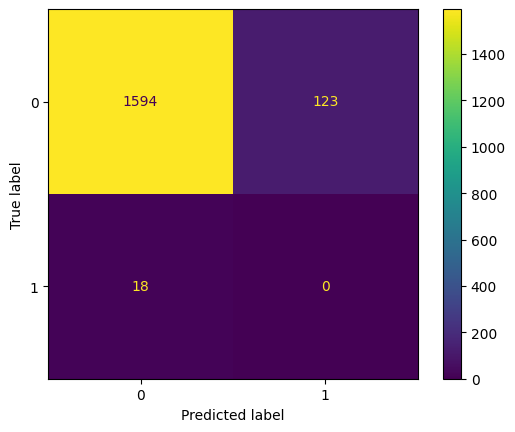

0.8738738738738738


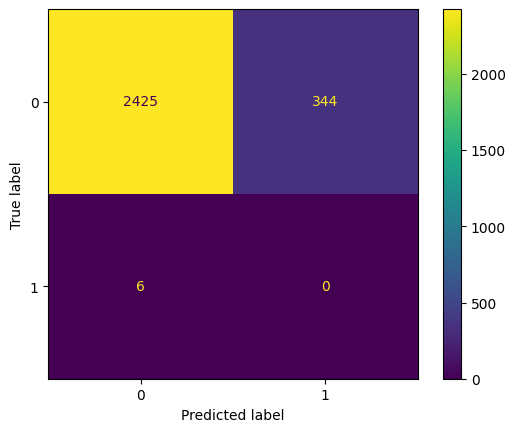

0.7516823687752355


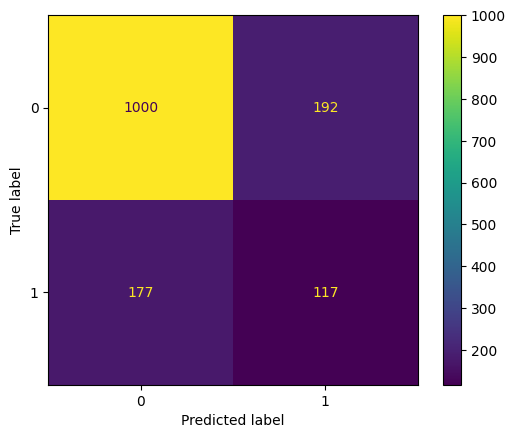

0.701688555347092


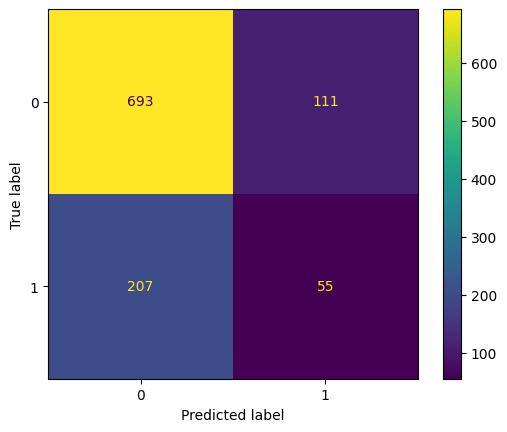

In [21]:
for d in ['easy', 'medium', 'hard', 'extra']:
    d_df = merged_df[merged_df['difficulty'] == d]
    d_df_labels = d_df['num_inner_queries'] > 0
    d_df_preds = d_df['nqt_len'] > 0

    print(sum(d_df_labels.values == d_df_preds.values) / len(d_df_preds))
    
    cm = confusion_matrix(d_df_labels.values, d_df_preds.values)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.show()

In [73]:
1/18

0.05555555555555555

In [72]:
2/6

0.3333333333333333

In [71]:
158/(112+158)

0.5851851851851851

In [70]:
157/(105+157)

0.5992366412213741

# Exploring GPT output

## Evidence Set

In [15]:
gpt_labels1.iloc[7]['question']

'Find the total number of scientists.'

In [16]:
gpt_labels1.iloc[7]['gpt_output']

'| Token            | Ontology Element    |\n| ---------------- | ------------------- |\n| total number     | `Scientists` (Count) |\n\nNote: In this case, the token "total number" is associated with the ontology element "Scientists" and the corresponding data property "Count" to retrieve the total count of scientists.'

In [17]:
postprocess_gpt_evidence_set(gpt_labels1.iloc[7]['gpt_output'])

[{'tokens': 'total number', 'table_name': 'Scientists', 'column_name': None}]

## Operation Types

In [18]:
gpt_labels2.iloc[12]['question']

'What are the maximum and minimum number of cows across all farms.'

In [19]:
sample_gpt_output = gpt_labels2.iloc[12]['gpt_output']

In [20]:
postprocess_gpt_operation_annotation(sample_gpt_output)

[{'tokens': 'maximum number of cows',
  'operation_type': 'AGGREGATION',
  'annotation': 'MAX(FARM.Cows)'},
 {'tokens': 'minimum number of cows',
  'operation_type': 'AGGREGATION',
  'annotation': 'MIN(FARM.Cows)'}]

In [23]:
merged_df[merged_df['question'] == "List the titles of books that are not published."].index

Index([1274], dtype='int64')

In [24]:
merged_df[merged_df['question'] == "Find the description of the most popular role among the users that have logged in."].index

Index([3420], dtype='int64')

In [25]:
create_annotated_tokens

<function athena_pp.nested_query_detection.create_annotated_tokens(database_tables_info, Q, gpt_evidence_set_postprocessed, gpt_operation_annotation_postprocessed)>

In [26]:
postprocess_gpt_operation_annotation

<function __main__.postprocess_gpt_operation_annotation(gpt_operation_annotation_output_string)>

In [27]:
test_idx = 1274
l = detect_nested_query_type(merged_df.iloc[test_idx]['db_id'], merged_df.iloc[test_idx]['question'], 
                            postprocess_gpt_evidence_set(merged_df.iloc[test_idx]['gpt_evidence_set']),
                            postprocess_gpt_operation_annotation(merged_df.iloc[test_idx]['gpt_operation_annotation']))
print(merged_df.iloc[test_idx]['question'])
for e in l:
    print(e.characters, e.nested_query_type)

not published NEGATION PUBLICATION.Publication_ID IS NULL
7 9
[<athena_pp.nested_query_detection.AnnotatedToken object at 0x000002569BDA0E80>, <athena_pp.nested_query_detection.AnnotatedToken object at 0x000002569BDA0280>, <athena_pp.nested_query_detection.AnnotatedToken object at 0x000002569C103FA0>, <athena_pp.nested_query_detection.AnnotatedToken object at 0x000002569C103E50>, <athena_pp.nested_query_detection.AnnotatedToken object at 0x000002569C103F10>, <athena_pp.nested_query_detection.AnnotatedToken object at 0x000002569C103B50>, <athena_pp.nested_query_detection.AnnotatedToken object at 0x000002569C103A60>, <athena_pp.nested_query_detection.AnnotatedToken object at 0x000002569C103D00>, <athena_pp.nested_query_detection.AnnotatedToken object at 0x000002569C1039A0>]
[]
[<athena_pp.nested_query_detection.AnnotatedToken object at 0x000002569C103D00>, <athena_pp.nested_query_detection.AnnotatedToken object at 0x000002569C1039A0>]
are | None | None None | None | False | 6 | # Spacy A

In [28]:
import pprint

In [29]:
nqTokens = l

In [30]:
database_tables_info = get_database_schema(merged_df.iloc[test_idx]['db_id'], return_table_dict=True)
annotated_tokens = create_annotated_tokens(database_tables_info,
                            merged_df.iloc[test_idx]['question'], 
                            postprocess_gpt_evidence_set(merged_df.iloc[test_idx]['gpt_evidence_set']),
                            postprocess_gpt_operation_annotation(merged_df.iloc[test_idx]['gpt_operation_annotation'])
                            )

not published NEGATION PUBLICATION.Publication_ID IS NULL
7 9


In [31]:
print('characters | db_table | db_column | op_annot | raw_op_annot | is_measure | word_idx | numeric | dep_idxs | nq_type')

for annot_t in annotated_tokens:
    print(annot_t)

characters | db_table | db_column | op_annot | raw_op_annot | is_measure | word_idx | numeric | dep_idxs | nq_type
List | None | None None | None | False | 0 | # Spacy Annotations False [2, 9, 0] | # nq annot: None
the | None | None None | None | False | 1 | # Spacy Annotations False [2] | # nq annot: None
titles | book | Title None | None | False | 2 | # Spacy Annotations False [1, 3, 8, 0] | # nq annot: None
of | book | Title None | None | False | 3 | # Spacy Annotations False [4, 2] | # nq annot: None
books | book | Title None | None | False | 4 | # Spacy Annotations False [3] | # nq annot: None
that | None | None None | None | False | 5 | # Spacy Annotations False [8] | # nq annot: None
are | None | None None | None | False | 6 | # Spacy Annotations False [8] | # nq annot: None
not | publication | Publication_ID NEGATION | PUBLICATION.Publication_ID IS NULL | True | 7 | # Spacy Annotations False [8] | # nq annot: None
published. | publication | Publication_ID NEGATION | PUBLICATION

In [32]:
ListES = []

for nqt in nqTokens:
    ES1 = set([(f'{t.related_database_table}.{t.related_database_column}' if t.related_database_column is not None else t.related_database_table)  for t in annotated_tokens[:nqt.word_idx] if t.related_database_table is not None])
    if nqt.word_idx < len(annotated_tokens) - 1:
        ES2 = set([(f'{t.related_database_table}.{t.related_database_column}' if t.related_database_column is not None else t.related_database_table)  for t in annotated_tokens[nqt.word_idx+1:] if t.related_database_table is not None])
    else:
        ES2 = set()

    print(nqt.characters, nqt.nested_query_type, ES1, ES2)

not TYPE-J {'book.Title'} {'publication.Publication_ID'}
published. TYPE-J {'book.Title', 'publication.Publication_ID'} set()


In [33]:
for e in nqTokens:
    print(e.nested_query_type)

TYPE-J
TYPE-J


In [34]:
def evidence_partitioning_algorithm(annotated_tokens):
    nqTokens = annotated_tokens
    
    ListES = []
    for nqt in nqTokens:
        ES1 = ES.before(nqTokens)
        ES2 = ES.after(nqTokens)

        if nqt.nested_query_type == 'TYPE-N':
            pass
        elif nqt.nested_query_type == 'TYPE-A':
            pass
        elif nqt.nested_query_type == 'TYPE-J':
            pass
        elif nqt.nested_query_type == 'TYPE-JA':
            pass
        ListES.append(ES1)
        ES = ES2
    ListES.append(ES)
    return ListES


In [35]:
from chatgpt import get_database_schema


In [36]:
database_tables_info = get_database_schema('book_2', return_table_dict=True)

In [37]:
postprocess_gpt_operation_annotation(merged_df.iloc[test_idx]['gpt_operation_annotation'])

[{'tokens': 'not published',
  'operation_type': 'NEGATION',
  'annotation': 'PUBLICATION.Publication_ID IS NULL'}]

In [38]:
tested_ats = create_annotated_tokens(database_tables_info,
                            merged_df.iloc[test_idx]['question'], 
                            postprocess_gpt_evidence_set(merged_df.iloc[test_idx]['gpt_evidence_set']),
                            postprocess_gpt_operation_annotation(merged_df.iloc[test_idx]['gpt_operation_annotation'])
                            )

not published NEGATION PUBLICATION.Publication_ID IS NULL
7 9


In [45]:
for i, at in enumerate(tested_ats):
    print(i, at)

0 None None None List ([2, 9, 0])
1 None None None the ([2])
2 None book Title titles ([1, 3, 8, 0])
3 None book Title of ([4, 2])
4 None book Title books ([3])
5 None None None that ([8])
6 None None None are ([8])
7 NEGATION publication Publication_ID not ([8])
8 NEGATION publication Publication_ID published. ([5, 6, 7, 2])


In [25]:
l.s

AttributeError: 'list' object has no attribute 'nested_query_type'

In [32]:
import spacy

In [33]:
nlp = spacy.load("en_core_web_sm")

In [34]:
doc = nlp(merged_df.iloc[test_idx]['question'])


In [44]:
for e in doc:
    print(e.head, e.head.idx)

List 0
titles 9
List 0
titles 9
of 16
published 38
published 38
published 38
titles 9
List 0


In [30]:
len(doc)

13

In [24]:
merged_df.iloc[test_idx]['question'].split()[10]

'each'

In [28]:
for token in doc:
    print(token.text, "-", token.head.text, [(child, child.idx) for child in token.children])

Give - Give [(years, 9), (., 67)]
the - years []
years - Give [(the, 5), (and, 15), (names, 28), (of, 34)]
and - years []
official - names []
names - years [(official, 19)]
of - years [(cities, 41)]
the - cities []
cities - of [(the, 37), (of, 48)]
of - cities [(competition, 56)]
each - competition []
competition - of [(each, 51)]
. - Give []


In [29]:
convert_string_idx_to_token_idx(merged_df.iloc[test_idx]['question'], 5)

1

In [47]:
doc[2].idx

9

In [19]:
sample_list = []

In [23]:
if sample_list:
    print(True)

In [22]:
l = create_annotated_tokens(gpt_labels2.iloc[10]['question'], 
                        postprocess_gpt_operation_annotation(gpt_labels2.iloc[10]['gpt_output']))

TypeError: create_annotated_tokens() missing 2 required positional arguments: 'gpt_evidence_set_postprocessed' and 'gpt_operation_annotation_postprocessed'

In [17]:
for e in l:
    print(e.annotation, e.characters)

None Give
None the
AGGREGATION average
AGGREGATION number
None of
None working
None horses
None on
None farms
None with
COMPARISON more
COMPARISON than
COMPARISON 5000
COMPARISON total
COMPARISON horses.


In [167]:
is_close_subsequence(corpus, query)

(3, 9)

In [168]:
corpus.split()[3:9]

['maximum', 'and', 'minimum', 'number', 'of', 'cows']

In [133]:
import re

In [134]:
pattern = re.match("^\s*(\S+)\s+(\S+\s*(\S+)?)?\s+(\S+),.*", verilogString)

NameError: name 'verilogString' is not defined

In [147]:
query = "maximum number of cows"
corpus = "What are the maximum and minimum number of cows across all farms."
match(corpus, query)

(-1, -1)

In [29]:
import spacy


In [30]:
from spacy.matcher import Matcher


In [31]:
nlp = spacy.load("en_core_web_sm")

In [109]:
matcher = Matcher(nlp.vocab)
pattern = [{"LOWER": "maximum"}, {"LOWER": "number"}, {"LOWER": "of"},  {"LOWER": "cows"}]
matcher.add("HelloWorld", [pattern])

In [110]:
doc = nlp("What are the maximum and minimum number of cows across all farms.")
matches = matcher(doc)

In [111]:
matches

[]

In [84]:
matches

[(16571425990740197027, 6, 7)]

In [91]:
query = "ipsum dolor"
corpus = "lorem 1psum d0l0r sit amet"

match = get_best_match(query, corpus)
pattern = [{"LOWER": "maximum number of cows"}]
matcher.add("HelloWorld", [pattern])

doc = nlp("Hello, world! Hello world!")
matches = matcher(doc)
for match_id, start, end in matches:
    string_id = nlp.vocab.strings[match_id]  # Get string representation
    span = doc[start:end]  # The matched span
    print(match_id, string_id, start, end, span.text)


15578876784678163569 HelloWorld 0 3 Hello, world
15578876784678163569 HelloWorld 4 6 Hello world


In [50]:
match

['psum d0l0r ']

In [49]:
quer

NameError: name 'quer' is not defined

In [35]:
first_query_response = sample_gpt_output.split("Query:")[0]
sample_gpt_output_lines = first_query_response.split("\n")

In [27]:
sample_gpt_output_lines

['| Tokens                        | Linguistic Pattern   | Reasoning                 |',
 '| ----------------------------- | -------------------- | ------------------------- |',
 '| total number of horses         | aggregation          |  SUM(FARM.Total_Horses)   |',
 '| on farms                      | -                    |  -                        |',
 '| in ascending order             | -                    |  -                        |',
 '',
 'In this query, there are no specific linguistic patterns related to comparison, negation, or other operations. The query is focused on obtaining the total number of horses on farms and ordering the result in ascending order.']

In [28]:
sample_gpt_output_lines[2].split("|")[-2].strip()

'SUM(FARM.Total_Horses)'

In [29]:
try:
    sample_gpt_output_lines[-1].split("|")[-2].strip()
except IndexError:
    print("index error")

index error


# Labeling difficulty

In [34]:
db_dir = os.getcwd()[:9] + os.path.join('tonyk', 'Downloads', 'spider', 'spider', 'database')

In [35]:
difficulty_labels = []
for _, r in weak_column_labels.iterrows():
    # print(eval_hardness(get_sql(r)))
    sql_string = r['Column1.query']
    db_id = r['Column1.db_id']
    db = os.path.join(db_dir, db_id, db_id + ".sqlite")
    try:
        db_schema = Schema(get_schema(db))
        g_sql = get_sql(db_schema, sql_string)
        difficulty_labels.append(eval_hardness(g_sql))
    except:
        difficulty_labels.append('error')

In [36]:
weak_column_labels['difficulty'] = difficulty_labels

In [42]:
weak_column_labels[weak_column_labels['Column1.question'] == 'What are the names, locations, and years of opening for tracks with seating higher than average?']

Unnamed: 0 Column1.db_id  \
758         758    race_track   

                                         Column1.query  \
758  SELECT name ,  LOCATION ,  year_opened FROM tr...   

                                      Column1.question Query Type Query Types  \
758  What are the names, locations, and years of op...        NaN  un-labeled   

                                          Evidence Set OPS COUNT  \
758  ['name', 'LOCATION', 'year_opened', 'seating',...        []   

              OPS AGG OPS COMPARISON OPS NEGATION difficulty  
758  ['avg(seating)']          ['>']           []      extra

In [44]:
weak_column_labels[weak_column_labels['Column1.question'] == 'What are the names, locations, and years of opening for tracks with seating higher than average?']['Column1.query'].iloc[0]

'SELECT name ,  LOCATION ,  year_opened FROM track WHERE seating  >  (SELECT avg(seating) FROM track)'

# Getting evidence set labels from LLM Output

In [33]:
re.findall(r'`(.*?)`', gpt_labels2['gpt_output'].iloc[5].split('Query')[0])

[]

# Joining GPT and Weak labels

In [34]:
gpt_labels2

db_id                                           question  \
0         farm                          How many farms are there?   
1         farm                          How many farms are there?   
2         farm                         Count the number of farms.   
3         farm  List the total number of horses on farms in as...   
4         farm  What is the total horses record for each farm,...   
...        ...                                                ...   
6941  soccer_2  Find the states where have the colleges whose ...   
6942  soccer_2  What are the states with colleges that have en...   
6943  soccer_2  Find names of colleges with enrollment greater...   
6944  soccer_2  What are the names of the colleges that are la...   
6945  soccer_2  Find names of all colleges whose enrollment is...   

                                             gpt_output added_date added_time  
0     | Tokens        | Linguistic Pattern | Reasoni...       None       None  
1     | Tokens        | Linguistic Pattern | Reasoni...       None       None  
2     | Tokens              | Linguistic Pattern | R...       None       None  
3     | Tokens                        | Linguistic P...       None       None  
4     | Tokens                        | Linguistic P...       None       None  
...                                                 ...        ...        ...  
6941  | Tokens                                | Ling...       None       None  
6942  | Tokens                                | Ling...       None       None  
6943  | Tokens                            | Linguist...       None       None  
6944  | Tokens                        | Linguistic P...       None       None  
6945  | Tokens                            | Linguist...       None       None  

[6946 rows x 5 columns]

In [35]:
weak_column_labels

Unnamed: 0          Column1.db_id  \
0              0  department_management   
1              1  department_management   
2              2  department_management   
3              3  department_management   
4              4  department_management   
...          ...                    ...   
6995        6995        culture_company   
6996        6996        culture_company   
6997        6997        culture_company   
6998        6998        culture_company   
6999        6999        culture_company   

                                          Column1.query  \
0            SELECT count(*) FROM head WHERE age  >  56   
1     SELECT name ,  born_state ,  age FROM head ORD...   
2     SELECT creation ,  name ,  budget_in_billions ...   
3     SELECT max(budget_in_billions) ,  min(budget_i...   
4     SELECT avg(num_employees) FROM department WHER...   
...                                                 ...   
6995  SELECT T1.company_name FROM culture_company AS...   
6996  SELECT T1.title ,  T3.book_title FROM movie AS...   
6997  SELECT T1.title ,  T3.book_title FROM movie AS...   
6998  SELECT T2.company_name FROM movie AS T1 JOIN c...   
6999  SELECT T2.company_name FROM movie AS T1 JOIN c...   

                                       Column1.question  Query Type  \
0     How many heads of the departments are older th...  non-nested   
1     List the name, born state and age of the heads...  non-nested   
2     List the creation year, name and budget of eac...  non-nested   
3     What are the maximum and minimum budget of the...  non-nested   
4     What is the average number of employees of the...  non-nested   
...                                                 ...         ...   
6995  What are all the company names that have a boo...         NaN   
6996  Show the movie titles and book titles for all ...         NaN   
6997  What are the titles of movies and books corres...         NaN   
6998  Show all company names with a movie directed i...         NaN   
6999  What are all company names that have a corresp...         NaN   

     Query Types                                       Evidence Set  \
0     un-labeled                                            ['age']   
1     un-labeled               ['name', 'born_state', 'age', 'age']   
2     un-labeled         ['creation', 'name', 'budget_in_billions']   
3     un-labeled                             ['budget_in_billions']   
4     un-labeled                       ['num_employees', 'ranking']   
...          ...                                                ...   
6995  un-labeled  ['culture_company.company_name', 'book_club.pu...   
6996  un-labeled  ['movie.title', 'book_club.book_title', 'cultu...   
6997  un-labeled  ['movie.title', 'book_club.book_title', 'cultu...   
6998  un-labeled     ['culture_company.company_name', 'movie.year']   
6999  un-labeled     ['culture_company.company_name', 'movie.year']   

         OPS COUNT                                            OPS AGG  \
0     ['count(*)']                                                 []   
1               []                                                 []   
2               []                                                 []   
3               []  ['max(budget_in_billions)', 'min(budget_in_bil...   
4               []                             ['avg(num_employees)']   
...            ...                                                ...   
6995            []                                                 []   
6996            []                                                 []   
6997            []                                                 []   
6998            []                                                 []   
6999            []                                                 []   

       OPS COMPARISON OPS NEGATION difficulty  
0               ['>']           []       easy  
1                  []           []     medium  
2                  []           []     medium  
3    

In [36]:
weak_column_labels[(weak_column_labels['difficulty'] == 'hard') & (weak_column_labels['Column1.db_id'] == 'book_2')]

Unnamed: 0 Column1.db_id  \
227         227        book_2   
229         229        book_2   
230         230        book_2   

                                         Column1.query  \
227  SELECT Publication_Date FROM publication GROUP...   
229  SELECT Title FROM book WHERE Book_ID NOT IN (S...   
230  SELECT Publisher FROM publication WHERE Price ...   

                                      Column1.question Query Type Query Types  \
227      Please show the most common publication date.        NaN  un-labeled   
229   List the titles of books that are not published.        NaN  un-labeled   
230  Show the publishers that have publications wit...        NaN  un-labeled   

                                 Evidence Set     OPS COUNT OPS AGG  \
227  ['Publication_Date', 'Publication_Date']  ['COUNT(*)']      []   
229           ['Title', 'Book_ID', 'Book_ID']            []      []   
230                    ['Publisher', 'Price']            []      []   

    OPS COMPARISON OPS NEGATION difficulty  
227             []           []       hard  
229             []           []       hard  
230     ['>', '<']           []       hard

In [37]:
merged_df =pd.merge(gpt_labels2, weak_column_labels,  how='left', left_on=['db_id','question'], right_on = ['Column1.db_id' ,'Column1.question'])


In [38]:
merged_df

db_id                                           question  \
0         farm                          How many farms are there?   
1         farm                          How many farms are there?   
2         farm                         Count the number of farms.   
3         farm  List the total number of horses on farms in as...   
4         farm  What is the total horses record for each farm,...   
...        ...                                                ...   
6959  soccer_2  Find the states where have the colleges whose ...   
6960  soccer_2  What are the states with colleges that have en...   
6961  soccer_2  Find names of colleges with enrollment greater...   
6962  soccer_2  What are the names of the colleges that are la...   
6963  soccer_2  Find names of all colleges whose enrollment is...   

                                             gpt_output added_date added_time  \
0     | Tokens        | Linguistic Pattern | Reasoni...       None       None   
1     | Tokens        | Linguistic Pattern | Reasoni...       None       None   
2     | Tokens              | Linguistic Pattern | R...       None       None   
3     | Tokens                        | Linguistic P...       None       None   
4     | Tokens                        | Linguistic P...       None       None   
...                                                 ...        ...        ...   
6959  | Tokens                                | Ling...       None       None   
6960  | Tokens                                | Ling...       None       None   
6961  | Tokens                            | Linguist...       None       None   
6962  | Tokens                        | Linguistic P...       None       None   
6963  | Tokens                            | Linguist...       None       None   

      Unnamed: 0 Column1.db_id  \
0             16          farm   
1             16          farm   
2             17          farm   
3             18          farm   
4             19          farm   
...          ...           ...   
6959        5038      soccer_2   
6960        5039      soccer_2   
6961        5040      soccer_2   
6962        5041      soccer_2   
6963        5042      soccer_2   

                                          Column1.query  \
0                             SELECT count(*) FROM farm   
1                             SELECT count(*) FROM farm   
2                             SELECT count(*) FROM farm   
3     SELECT Total_Horses FROM farm ORDER BY Total_H...   
4     SELECT Total_Horses FROM farm ORDER BY Total_H...   
...                                                 ...   
6959  SELECT DISTINCT state FROM college WHERE enr  ...   
6960  SELECT DISTINCT state FROM college WHERE enr  ...   
6961  SELECT DISTINCT cName FROM college WHERE enr  ...   
6962  SELECT DISTINCT cName FROM college WHERE enr  ...   
6963  SELECT cName FROM college WHERE enr  >  (SELEC...   

                                       Column1.question Query Type  \
0                             How many farms are there?        NaN   
1                             How many farms are there?        NaN   
2                            Count the number of farms.        NaN   
3     List the total number of horses on farms in as...        NaN   
4     What is the total horses record for each farm,...        NaN   
...                                                 ...        ...   
6959  Find the states where have the colleges whose ...        NaN   
6960  What are the states with colleges that have en...        NaN   
6961  Find names of colleges with enrollment greater...        NaN   
6962  What are the names of the colleges that are la...        NaN   
6963  Find names of all colleges whose enrollment is...        NaN   

     Query Types                      Evidence Set     OPS COUNT  \
0     un-labeled                          ['farm']  ['count(*)']   
1     un-labeled                          ['farm']  ['count(*)']   
2     un-labeled                          ['

In [39]:
def score_weak_label_columns_in_llm_evidence_set(llm_evidence_set, weak_label_columns):
    # presence = True
    for c in weak_label_columns:
        substring_present = any(c in s for s in llm_evidence_set)
        if substring_present is False:
            return False
    return True
        # print(substring_present)

In [40]:
def check_correctness_of_presence(set_a, set_b):
    if len(set_a) == 0 and len(set_b) == 0:
        return True
    elif len(set_a) > 0 and len(set_b) > 0:
        return True
    return False


In [41]:
was_count_correct = []
was_agg_correct = []
was_comparison_correct = []
was_negation_correct = []

count_correct = 0
agg_correct = 0
comparison_correct = 0
negation_correct = 0

total = 0
for i, r in merged_df.iterrows():
    gpt_output = r['gpt_output']
    gpt_first_query_response = gpt_output.split("Query:")[0]
    gpt_output_lines = gpt_first_query_response.split("\n")
    
    op_annotations = []
    for l in gpt_output_lines[2:]:
        try:
            annotation = l.split("|")[-2].strip()
            op_annotations.append(annotation)
        except IndexError:
            pass

    # print(op_annotations)
    weak_label_count_sql = ast.literal_eval(r['OPS COUNT'])
    weak_label_agg_sql = ast.literal_eval(r['OPS AGG'])
    weak_label_comparison_sql = ast.literal_eval(r['OPS COMPARISON'])
    weak_label_negation_sql = ast.literal_eval(r['OPS NEGATION'])

    
    # print(op_annotations, weak_label_count_sql, weak_label_agg_sql)

    # # print(type(weak_label_evidence_set))
    gpt_op_annotations = [x.lower() for x in op_annotations]
    weak_label_count_sql = [x.lower() for x in weak_label_count_sql]
    weak_label_agg_sql = [x.lower() for x in weak_label_agg_sql]
    weak_label_comparison_sql = [x.lower() for x in weak_label_comparison_sql]
    weak_label_negation_sql = [x.lower() for x in weak_label_negation_sql]

    
    # weak_label_evidence_set = filter(lambda x: 'id' not in x, weak_label_evidence_set)
    # # print(i, gpt_evidence_set, weak_label_evidence_set)

    # if score_weak_label_columns_in_llm_evidence_set(gpt_op_annotations, weak_label_count_sql):
    #     count_correct += 1
    #     was_count_correct.append(1)
    # else:
    #     was_count_correct.append(0)
    
    # if score_weak_label_columns_in_llm_evidence_set(gpt_op_annotations, weak_label_agg_sql):
    #     agg_correct += 1
    #     was_agg_correct.append(1)
    # else:
    #     was_agg_correct.append(0)


    gpt_count_operations =  [s for s in gpt_op_annotations if any(ele.lower() in s.lower() for ele in COUNT_OPS)]
    gpt_agg_operations =  [s for s in gpt_op_annotations if any(ele.lower() in s.lower() for ele in AGG_OPS)]
    gpt_comparison_operations =  [s for s in gpt_op_annotations if any(ele.lower() in s.lower() for ele in COMPARISON_OPS) and not any(ele.lower() in s.lower() for ele in NEGATION_OPS)]
    gpt_negation_operations =  [s for s in gpt_op_annotations if any(ele.lower() in s.lower() for ele in NEGATION_OPS)]

    if check_correctness_of_presence(set(gpt_count_operations), set(weak_label_count_sql)):
        # count_correct
    # if set(gpt_count_operations) == set(weak_label_count_sql):
        count_correct += 1
        was_count_correct.append(1)
    else:
        was_count_correct.append(0)

    
    if check_correctness_of_presence(set(gpt_agg_operations), set(weak_label_agg_sql)):

    # if set(gpt_agg_operations) == set(weak_label_agg_sql):
        agg_correct += 1
        was_agg_correct.append(1)
    else:
        was_agg_correct.append(0)
   
    
    
    
    if check_correctness_of_presence(set(gpt_comparison_operations), set(weak_label_comparison_sql)):
        # count_correct
        comparison_correct += 1
        was_comparison_correct.append(1)
    else:
        was_comparison_correct.append(0)

    
    if check_correctness_of_presence(set(gpt_negation_operations), set(weak_label_negation_sql)):

    # if set(gpt_agg_operations) == set(weak_label_agg_sql):
        negation_correct += 1
        was_negation_correct.append(1)
    else:
        was_negation_correct.append(0)
    # break
    
    total += 1
    
print(count_correct / total)
print(agg_correct / total)
print(comparison_correct / total)
print(negation_correct / total)

0.9533314187248708
0.8658816771970133
0.8229465824238943
0.9844916714531878


In [42]:
print((correct + 4) / total)

NameError: name 'correct' is not defined

In [43]:
merged_df['count_matched'] = was_count_correct
merged_df['agg_matched'] = was_agg_correct
merged_df['comparison_matched'] = was_comparison_correct
merged_df['negation_matched'] = was_negation_correct

In [44]:
merged_df[(merged_df['difficulty'] == 'hard') & (merged_df['Column1.db_id'] == 'book_2')]

db_id                                           question  \
1273  book_2      Please show the most common publication date.   
1275  book_2   List the titles of books that are not published.   
1276  book_2  Show the publishers that have publications wit...   

                                             gpt_output added_date added_time  \
1273  | Tokens                        | Linguistic P...       None       None   
1275  | Tokens                        | Linguistic P...       None       None   
1276  | Tokens                                      ...       None       None   

      Unnamed: 0 Column1.db_id  \
1273         227        book_2   
1275         229        book_2   
1276         230        book_2   

                                          Column1.query  \
1273  SELECT Publication_Date FROM publication GROUP...   
1275  SELECT Title FROM book WHERE Book_ID NOT IN (S...   
1276  SELECT Publisher FROM publication WHERE Price ...   

                                       Column1.question Query Type  ...  \
1273      Please show the most common publication date.        NaN  ...   
1275   List the titles of books that are not published.        NaN  ...   
1276  Show the publishers that have publications wit...        NaN  ...   

                                  Evidence Set     OPS COUNT OPS AGG  \
1273  ['Publication_Date', 'Publication_Date']  ['COUNT(*)']      []   
1275           ['Title', 'Book_ID', 'Book_ID']            []      []   
1276                    ['Publisher', 'Price']            []      []   

     OPS COMPARISON OPS NEGATION difficulty count_matched  agg_matched  \
1273             []           []       hard             0            1   
1275             []           []       hard             1            1   
1276     ['>', '<']           []       hard             1            1   

      comparison_matched  negation_matched  
1273                   1                 1  
1275                   1                 1  
1276                   1                 1  

[3 rows x 21 columns]

In [45]:
accuracy_statistics = merged_df.groupby(by=['difficulty']).agg({
    'count_matched':['count', 'sum'],
    'agg_matched':['count', 'sum'],
    'comparison_matched':['count', 'sum'],
    'negation_matched':['count', 'sum'],

                                                               
                                                               })

In [46]:
accuracy_statistics[('count_matched', 'sum')] / accuracy_statistics[('count_matched', 'count')]

difficulty
easy      0.974691
error     1.000000
extra     0.912796
hard      0.918621
medium    0.973904
dtype: float64

In [47]:
accuracy_statistics[('agg_matched', 'sum')] / accuracy_statistics[('agg_matched', 'count')]

difficulty
easy      0.969982
error     0.000000
extra     0.725118
hard      0.814483
medium    0.882929
dtype: float64

In [48]:
accuracy_statistics[('comparison_matched', 'sum')] / accuracy_statistics[('comparison_matched', 'count')]

difficulty
easy      0.933490
error     0.000000
extra     0.634123
hard      0.815172
medium    0.831461
dtype: float64

In [49]:
accuracy_statistics[('negation_matched', 'sum')] / accuracy_statistics[('negation_matched', 'count')]

difficulty
easy      0.974102
error     1.000000
extra     0.984834
hard      0.986207
medium    0.989851
dtype: float64

In [50]:
accuracy_statistics.loc[:].columns

MultiIndex([(     'count_matched', 'count'),
            (     'count_matched',   'sum'),
            (       'agg_matched', 'count'),
            (       'agg_matched',   'sum'),
            ('comparison_matched', 'count'),
            ('comparison_matched',   'sum'),
            (  'negation_matched', 'count'),
            (  'negation_matched',   'sum')],
           )

In [51]:
merged_df['estimated_nested_query_classifier'] = merged_df[['count_matched', 'agg_matched', 'comparison_matched', 'negation_matched']].all(axis=1)

In [52]:
estimated_nested_query_classifier_accuracy = merged_df.groupby(by=['difficulty']).agg({
    'estimated_nested_query_classifier':['count', 'sum'],
})

In [53]:
estimated_nested_query_classifier_accuracy[('estimated_nested_query_classifier', 'sum')] / estimated_nested_query_classifier_accuracy[('estimated_nested_query_classifier', 'count')]

difficulty
easy      0.888758
error     0.000000
extra     0.473934
hard      0.618621
medium    0.718739
dtype: float64

In [54]:
merged_df['estimated_nested_query_classifier'].sum()  / len(merged_df)

0.7021826536473291

In [29]:
merged_df.groupby(by=['difficulty']).count()

db_id  question  gpt_output  added_date  added_time  Unnamed: 0  \
difficulty                                                                    
easy         1699      1699        1699           0           0        1699   
error           1         1           1           0           0           1   
extra        1055      1055        1055           0           0        1055   
hard         1450      1450        1450           0           0        1450   
medium       2759      2759        2759           0           0        2759   

            Column1.db_id  Column1.query  Column1.question  Query Type  \
difficulty                                                               
easy                 1699           1699              1699           5   
error                   1              1                 1           0   
extra                1055           1055              1055           2   
hard                 1450           1450              1450           2   
medium               2759           2759              2759           7   

            Query Types  Evidence Set  OPS COUNT  OPS AGG  OPS COMPARISON  \
difficulty                                                                  
easy               1699          1699       1699     1699            1699   
error                 1             1          1        1               1   
extra              1055          1055       1055     1055            1055   
hard               1450          1450       1450     1450            1450   
medium             2759          2759       2759     2759            2759   

            OPS NEGATION  count_matched  agg_matched  
difficulty                                            
easy                1699           1699         1699  
error                  1              1            1  
extra               1055           1055         1055  
hard                1450           1450         1450  
medium              2759           2759         2759

In [30]:
accuracy_statistics_2 = merged_df.groupby(by=['difficulty']).agg({'agg_matched':['count', 'sum']})

In [31]:
accuracy_statistics_2

agg_matched      
                 count   sum
difficulty                  
easy              1699  1648
error                1     0
extra             1055   765
hard              1450  1181
medium            2759  2436

In [32]:
accuracy_statistics_2

agg_matched      
                 count   sum
difficulty                  
easy              1699  1648
error                1     0
extra             1055   765
hard              1450  1181
medium            2759  2436

In [33]:
accuracy_statistics_2[('agg_matched', 'sum')] / accuracy_statistics_2[('agg_matched', 'count')]

difficulty
easy      0.969982
error     0.000000
extra     0.725118
hard      0.814483
medium    0.882929
dtype: float64

In [75]:
for i, r in merged_df[merged_df['count_matched']  == 0].iterrows():
    gpt_evidence_set_output = r['gpt_output']
    # gpt_evidence_set = re.findall(r'`(.*?)`', gpt_evidence_set_output.split('Query')[0])
    weak_label_evidence_set = ast.literal_eval(r['OPS COUNT'])
    
    print(i, gpt_evidence_set_output, weak_label_evidence_set)

14 | Tokens                        | Linguistic Pattern   | Reasoning                 |
| ----------------------------- | -------------------- | ------------------------- |
| How many different statuses    | aggregation          |  COUNT(DISTINCT city.Status) |
| do cities have?                | none                 |  N/A                      |

In this query, there are no specific linguistic patterns related to aggregation, comparison, or negation. The query is asking for the count of different statuses that cities have, which requires an aggregation function (COUNT) and the use of DISTINCT to count only unique values. There are no comparison or negation operations involved in this query. ['count(DISTINCT']
15 | Tokens                        | Linguistic Pattern   | Reasoning                 |
| ----------------------------- | -------------------- | ------------------------- |
| Count the number of            | count                |  COUNT(DISTINCT city.Status) |
| different statuse

In [27]:
merged_df.iloc[490 ]

db_id                                                              wine_1
question                    Find the names of all wines produced in 2008.
gpt_evidence_set        | Token                   | Ontology Element |...
added_date                                                17:46:35.941132
added_time                               2023-10-17 00:46:35.941132+00:00
Unnamed: 0                                                           6521
Column1.db_id                                                      wine_1
Column1.query                 SELECT Name FROM WINE WHERE YEAR  =  "2008"
Column1.question            Find the names of all wines produced in 2008.
Query Type                                                            NaN
Query Types                                                    non-nested
Evidence Set                                             ['Name', '2008']
evidence_set_matched                                                    0
Name: 490, dtype: object

In [52]:
merged_df.iloc[57]['gpt_evidence_set']

'| Token                                | Ontology Element                |\n| ------------------------------------ | ------------------------------- |\n| branches                             | `branch`                        |\n| average number of memberships         | `membership_register_branch`    |\n| number of memberships                 | `membership_register_branch`    |\n\nQuery:\nFind the total pounds spent by each member at each branch in the year 2022.\n\nTable:\n| Token                                | Ontology Element                |\n| ------------------------------------ | ------------------------------- |\n| total pounds                         | `purchase.Total_pounds`         |\n| member                               | `purchase.Member_ID`            |\n| branch                               | `purchase.Branch_ID`            |\n| year                                 | `purchase.Year`                 |\n\nQuery:\nList all projects located in New York.\n\nTable:\n| To

In [45]:
merged_df.iloc[8]['GPT.Evidence_Set']

KeyError: 'GPT.Evidence_Set'

In [46]:
weak_column_labels['Evidence Set'].iloc[0]

"['age']"

In [35]:
for c in re.findall(r'`(.*?)`', gpt_labels['GPT.Evidence_Set'].iloc[5].split('Query')[0]):
    prin

['COUNT(Student)', 'COUNT']

In [24]:
gpt_labels.iloc[16]

Unnamed: 0                                                         16
db_id                                                         wedding
question              How many churches opened before 1850 are there?
GPT.Evidence_Set    | Token                          | Ontology El...
Name: 16, dtype: object

In [ ]:
import re
>>> string = '"Foo Bar" "Another Value"'
>>> print re.findall(r'"(.*?)"', string)
['Foo Bar', 'Another Value']